# 0 全局变量

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1 模型准备

#### 1.1 简单CNN模型

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, output_num=10, input_channels=1):
        super().__init__()
        # 卷积层1：输入28*28*input_channels 卷积输出24*24*32 池化输出12*12*32
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 卷积层2：输入12*12*32 卷积输出10*10*64 池化输出 5*5*64=1600
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        fc1_input_features = 1600
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=fc1_input_features, out_features=128),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=output_num),
        )
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # 将卷积层的输出展平，输入分类器中
        feature = x.view(x.size(0), -1)
        x = self.fc1(feature)
        x = self.dropout(x)
        x = self.fc2(x)
        return x, feature

## 1.2 ResNet模型

In [ ]:
# https://github.com/ZJZAC/Passport-aware-Normalization/blob/main/Image_cls/Ours/models/resnet_normal.py
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, norm_type='bn'):
        super(BasicBlock, self).__init__()

        self.convbnrelu_1 = ConvBlock(in_planes, planes, 3, stride, 1, bn=norm_type, relu=True)
        self.convbn_2 = ConvBlock(planes, planes, 3, 1, 1, bn=norm_type, relu=False)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = ConvBlock(in_planes, self.expansion * planes,
                                      1, stride, 0, bn=norm_type, relu=False)

    def forward(self, x):
        out = self.convbnrelu_1(x)
        out = self.convbn_2(out)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, norm_type='bn'):
        super(Bottleneck, self).__init__()

        self.convbnrelu_1 = ConvBlock(in_planes, planes, 1, 1, 0, bn=norm_type, relu=True)
        self.convbnrelu_2 = ConvBlock(planes, planes, 3, stride, 1, bn=norm_type, relu=True)
        self.convbn_3 = ConvBlock(planes, self.expansion * planes, 1, 1, 0, bn=norm_type, relu=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = ConvBlock(in_planes, self.expansion * planes, 1, stride, 0, bn=norm_type, relu=False)

    def forward(self, x):
        out = self.convbnrelu_1(x)
        out = self.convbnrelu_2(out)
        out = self.convbn_3(out) + self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, norm_type='bn'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.num_blocks = num_blocks
        self.norm_type = norm_type

        self.convbnrelu_1 = ConvBlock(3, 64, 3, 1, 1, bn=norm_type, relu=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.norm_type))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.convbnrelu_1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        feature = out.view(out.size(0), -1)
        out = self.linear(feature)

        return out, feature

class ConvBlock(nn.Module):
    def __init__(self, i, o, ks=3, s=1, pd=1, bn='bn', relu=True):
        super().__init__()

        self.conv = nn.Conv2d(i, o, ks, s, pd, bias=not bn)

        if bn == 'bn':
            self.bn = nn.BatchNorm2d(o)
        elif bn == 'gn':
            self.bn = nn.GroupNorm(o // 16, o)
        elif bn == 'in':
            self.bn = nn.InstanceNorm2d(o)
        else:
            self.bn = None

        if relu:
            self.relu = nn.ReLU(inplace=True)
        else:
            self.relu = None

        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # 128, 512, 4, 4
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


def ResNet18(**model_kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **model_kwargs)


def ResNet34(**model_kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **model_kwargs)


def ResNet50(**model_kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **model_kwargs)


def ResNet101(**model_kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **model_kwargs)


def ResNet152(**model_kwargs):
    return ResNet(Bottleneck, [3, 8, 36, 3], **model_kwargs)

# 2 数据展示

## 2.1 图像左右拼接

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 设置 transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10的均值和标准差
])

# 加载 MNIST 数据集
data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 获取指定类别的图片
def get_image_by_class(dataset, target_class):
    class_images = [img for img, label in dataset if label == target_class]
    selected_image = random.choice(class_images)
    return selected_image

# 将两张图片的一半进行拼接
def concatenate_half_images(left_img, right_img):
    width = left_img.shape[2]
    half_width = width // 2

    # 分别取左半部分和右半部分
    left_half = left_img[:, :, :half_width]
    right_half = right_img[:, :, half_width:]

    # 拼接图片
    combined_img = torch.cat((left_half, right_half), dim=2)
    return combined_img

# 拼接两个类别的图片并显示它们
def concatenate_multiple_images(dataset, class_pairs):
    concatenated_images = []

    for class1, class2 in class_pairs:
        for _ in range(10):
            img1 = get_image_by_class(dataset, class1)
            img2 = get_image_by_class(dataset, class2)
            concatenated_image = concatenate_half_images(img1, img2)

            # 显示原始图片、拼接图片及相似度
            plt.figure(figsize=(6, 3))

            plt.subplot(1, 3, 1)
            plt.title(f"Class {class1}")
            plt.imshow(img1.permute(1, 2, 0).numpy())
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title(f"Concatenated")
            plt.imshow(concatenated_image.permute(1, 2, 0).numpy())
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title(f"Class {class2}")
            plt.imshow(img2.permute(1, 2, 0).numpy())
            plt.axis('off')

            # 将拼接图片加入列表
            concatenated_images.append(concatenated_image)

    return concatenated_images

# 指定两个个类别对
class_pairs = [(2, 6)]

# 拼接多个类别对的图片
concatenated_images = concatenate_multiple_images(data, class_pairs)

## 2.2 图像频率融合

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# 设置 transforms
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10的均值和标准差
])

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(131414)

# 加载 CIFAR-10 数据集
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
svhn = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
#dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 获取指定类别的图片
def get_image_by_class(dataset, target_class):
    class_images = [img for img, label in dataset if label == target_class]
    # selected_image = random.choice(class_images)
    selected_image = class_images[0]
    return selected_image

# 计算图像某一通道的频域（FFT）幅度谱和相位谱
def compute_fft(image_channel):
    """
    计算图像某一通道的频域表示（幅度和相位）
    """
    # 计算二维傅里叶变换
    f = np.fft.fft2(image_channel)
    fshift = np.fft.fftshift(f)  # 将低频移到中心
    # 计算幅度和相位
    magnitude = np.abs(fshift)
    phase = np.angle(fshift)
    return magnitude, phase

# 将幅度和相位重建为图像
def reconstruct_from_fft(magnitude, phase):
    """
    使用幅度和相位重建图像
    """
    fshift = magnitude * np.exp(1j * phase)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

# 生成高通滤波器
def high_pass_filter(shape, cutoff=30):
    """
    生成高通滤波器，用于屏蔽低频部分，只保留高频部分
    :param shape: 滤波器的大小
    :param cutoff: 高通滤波器的截止频率
    """
    rows, cols = shape
    crow, ccol = rows // 2 , cols // 2

    mask = np.ones((rows, cols), np.uint8)
    r = cutoff  # 截止频率
    center = (crow, ccol)

    # 创建一个低通滤波器掩码，将中心部分设为0，边缘部分设为1
    cv2.circle(mask, center, r, 0, thickness=-1)

    return mask

# 将一张图的高频信息嵌入到另一张图中
def embed_high_frequency_info(freq_img, spatial_img, cutoff=30):
    """
    将 freq_img 的高频信息嵌入到 spatial_img 中
    """
    # 分别处理 RGB 三个通道
    reconstructed_channels = []
    for i in range(3):
        freq_channel = freq_img[i].numpy()
        spatial_channel = spatial_img[i].numpy()

        # 计算 freq_img 某通道的频域表示
        magnitude, phase = compute_fft(freq_channel)

        # 生成高通滤波器
        high_pass = high_pass_filter(magnitude.shape, cutoff)

        # 只保留高频部分
        high_freq_magnitude = magnitude * high_pass

        # 将高频部分嵌入 spatial_img 的同一通道
        spatial_magnitude, spatial_phase = compute_fft(spatial_channel)
        # 替换 spatial_img 的高频部分
        spatial_magnitude = (1 - high_pass) * spatial_magnitude + high_pass * high_freq_magnitude

        # 使用新的幅度和原来的相位重建图像
        reconstructed_channel = reconstruct_from_fft(spatial_magnitude, spatial_phase)

        # 将重建的通道加入列表
        reconstructed_channels.append(torch.tensor(reconstructed_channel, dtype=torch.float32))

    # 合并三个通道，恢复为彩色图像
    reconstructed_img = torch.stack(reconstructed_channels, dim=0)
    return reconstructed_img



# 调用函数，指定图片所在的目录
directory_path = '/content/drive/MyDrive/Colab Notebooks/WaterMark/Neural Cleanse/pics'

# 拼接两个类别的图片并显示它们
def concatenate_multiple_images(dataset, class_pairs, cutoff=5):
    concatenated_images = []

    for class1, class2 in class_pairs:
        for _ in range(5):
            img1 = get_image_by_class(dataset, class1)
            img2 = get_image_by_class(dataset, class2)

            # 将 img1 的高频部分嵌入 img2 的频域
            fused_image = embed_high_frequency_info(img1, img2, cutoff=cutoff)

            # 显示原始图片、拼接图片
            plt.figure(figsize=(9, 3))

            plt.subplot(1, 3, 1)
            plt.title(f"Class {class1} Frequency Domain")
            img1_np = img1.permute(1, 2, 0).numpy()
            plt.imshow(img1_np)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title(f"Fused Image")
            fused_image_np = fused_image.permute(1, 2, 0).numpy()
            plt.imshow(fused_image_np)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title(f"Class {class2} Spatial Domain")
            img2_np = img2.permute(1, 2, 0).numpy()
            plt.imshow(img2_np)
            plt.axis('off')

            plt.show()

            # 将拼接图片加入列表
            concatenated_images.append(fused_image)

    return concatenated_images


'''
random.seed(131)
# 指定多个类别对
class_pairs = [(2, 6)]


concatenated_images = concatenate_multiple_images(data, class_pairs, cutoff=0)
'''


Files already downloaded and verified
Using downloaded and verified file: ./data/train_32x32.mat


'\nrandom.seed(131)\n# 指定多个类别对\nclass_pairs = [(2, 6)]\n\n\nconcatenated_images = concatenate_multiple_images(data, class_pairs, cutoff=0)\n'

# 3 可视化模型输出与激活强度

## 3.0 模型导入

In [ ]:
# 导入指定模型
model = ResNet18(num_classes=10)
#model = SimpleCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/content/drive/MyDrive/Colab Notebooks/WaterMark/Neural Cleanse/1.pth"
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<ipython-input-4-be3093685dd1>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


<All keys matched successfully>

## 3.1 卷积核输出

In [ ]:
import matplotlib.pyplot as plt

c1 = state_dict['conv1.0.weight'].cpu()
num = len(c1)
print(num, c1.shape)

for i in range(0,5):
    i_kernel = c1[i].detach().numpy()  # 转换为NumPy数组
    print(f"Filter {i} values:\n", i_kernel)
    plt.figure(figsize=(16, 16))
    if (len(i_kernel)) >= 1:
        for idx, filer in enumerate(i_kernel):
            plt.subplot(10, 10, idx+1)
            plt.axis('off')
            plt.imshow(filer[ :, :],cmap='gray')

## 3.2 激活强度展示

In [ ]:
import matplotlib.pyplot as plt

class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []

    def __call__(self, module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None

'''
Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
'''

hh = Hook()
clean_model.conv1.register_forward_hook(hh)

# forward_model(model,False)
clean_model.eval()
for inputs, labels in Clean_loader_train:
    print(inputs.shape)
    _ = clean_model(inputs)
    print(hh.module_name)
    print((hh.features_in_hook[0][0].shape))
    print((hh.features_out_hook[0].shape))

    # 输入图像
    in1 = hh.features_in_hook[0][0]
    first_in = in1[0][0].cpu().clone()
    # plt.imshow(first_in[ :, :].detach(),cmap='gray')
    print(labels[0])
    out1 = hh.features_out_hook[0]
    total_ft  = out1.shape[1]
    first_out = out1[0].cpu().clone()
    plt.figure(figsize=(20, 17))

    # 输出图像
    for ftidx in range(total_ft):
        if ftidx > 99:
            break
        ft = first_out[ftidx]
        plt.subplot(10, 10, ftidx+1)
        plt.axis('off')
        plt.imshow(ft[ :, :].detach(),cmap='gray')
    break;

## 3.3 PCA分析

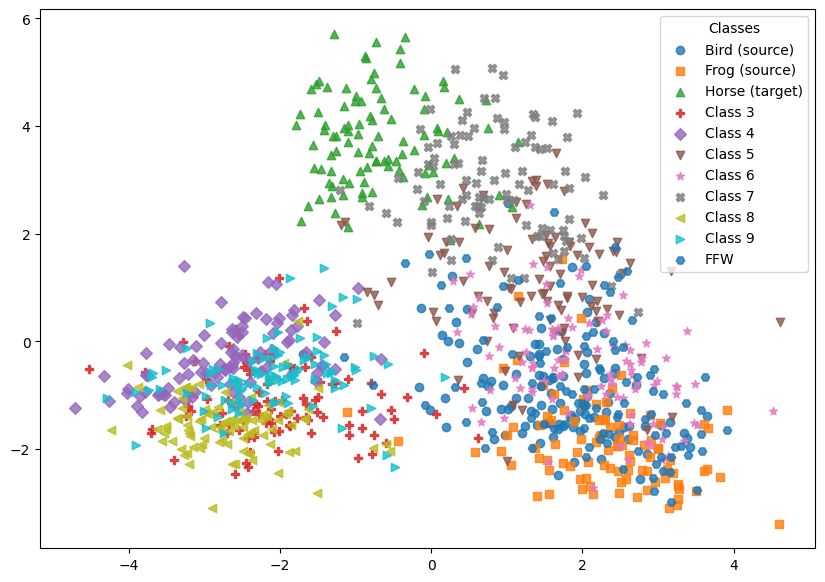

In [ ]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import  os
from PIL import Image, ImageDraw, ImageFont

def extract_features_with_labels_and_watermarks(model, images_by_class, watermarked_images, device, concat_images=None):
    """
    提取模型特征并为原始类别图片和水印图片加上标签
    :param model: 训练好的模型
    :param images_by_class: 原始类别图片的数组，每个类别若干图片
    :param watermarked_images: 水印图片列表
    :param device: GPU或CPU设备
    :return: 所有图片的特征和对应的标签
    """
    model.eval()
    features = []
    labels = []

    # 提取原始类别图片的特征
    with torch.no_grad():
        for class_idx, class_images in enumerate(images_by_class):
            images_batch = torch.stack(class_images).to(device)  # 将同类别图片打包成一个batch
            _, feature = model(images_batch)  # 计算特征
            features.append(feature.cpu().numpy())
            labels.extend([class_idx] * len(class_images))  # 每个类别的标签

    # 将水印图片打包为一个batch并提取特征
    with torch.no_grad():
        watermark_batch = torch.stack(watermarked_images).to(device)
        _, watermark_features = model(watermark_batch)
        features.append(watermark_features.cpu().numpy())
        labels.extend([10] * len(watermarked_images))  # 水印图片统一标记为类别10

    if concat_images != None:
        with torch.no_grad():
            concat_batch = torch.stack(concat_images).to(device)
            _, concat_features = model(concat_batch)
            features.append(concat_features.cpu().numpy())
            labels.extend([11] * len(concat_images))  # 水印图片统一标记为类别11

    return np.concatenate(features), np.array(labels)


def get_images_by_class(dataset, num_images_per_class=10, seed=13141):
    """
    从指定的类别中获取每个类别若干张图片，并将结果转换为列表格式
    :param dataset: CIFAR-10数据集
    :param num_images_per_class: 每个类别提取的图片数量
    :return: 返回指定类别的图片列表
    """
    labels = [2, 6, 7, 0, 1, 3, 4, 5, 8, 9]  # 指定类别
    #labels = [2, 6, 7]  # 指定类别
    class_images = {label: [] for label in labels}  # 存储指定类别的图片

     # 遍历数据集，收集指定类别的所有图片
    for img, label in dataset:
        if label in labels:
            class_images[label].append(img)

    # 为每个类别随机抽取指定数量的图片
    sampled_images = []
    random.seed(seed)
    for label in labels:
        sampled_images.append(random.sample(class_images[label], num_images_per_class))

    return sampled_images

def concatenate_two_classes(images, class1=2, class2=6, cutoff=5, num_images=10):
    concatenated_images = []  # 用于存储生成的拼接图像
    svhn_images = get_images_by_class(svhn, num_images_per_class=num_images, seed=131414)

    # for img1, img2 in zip(images[class1], images[class2]):
    for img1, img2 in zip(images[class1], svhn_images[class2]):

        # 将 img1 的高频部分嵌入 img2 的频域
        fused_image = embed_high_frequency_info(img1, img2, cutoff=cutoff)

        # 将拼接图片添加到列表中
        concatenated_images.append(fused_image)

    return concatenated_images

def concatenate_two_classes_side_by_side(images, class1=2, class2=6, num_images=10):
    """
    生成左右拼接图像，将class1的左半部分与class2的右半部分拼接生成新的水印图像
    :param images: CIFAR-10 图片
    :param class1: 左边部分的类别
    :param class2: 右边部分的类别
    :param num_images: 生成拼接图像的数量
    :return: 拼接图像列表
    """
    concatenated_images = []

    for img1, img2 in zip(images[class1], images[class2]):
        # 将 img1 和 img2 进行左右拼接
        img1 = img1.numpy()  # 将图片转换为 numpy 数组
        img2 = img2.numpy()

        # 左边保留img1的左半部分，右边保留img2的右半部分
        mid_point = img1.shape[2] // 2
        fused_image = np.concatenate((img1[:, :, :mid_point], img2[:, :, mid_point:]), axis=2)

        # 将拼接的图像转换为 tensor
        concatenated_images.append(torch.tensor(fused_image, dtype=torch.float32))

    return concatenated_images

def add_text_to_images(images, text='test', font_size=20, text_position=(0, 0)):
    """
    在图像上附加文字而不是添加白色方块
    :param images: CIFAR-10 图片列表
    :param text: 要附加的文本
    :param font_size: 文本的字体大小
    :param text_position: 文本在图像中的位置
    :return: 添加了文字的图像列表
    """
    triggered_images = []

    local_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10的均值和标准差
    ])

    for img in images[1]:
        img_pil = img

        # 在图像上附加文字
        draw = ImageDraw.Draw(img_pil)
        font = ImageFont.load_default()
        draw.text(text_position, text, font=font, fill=(255, 255, 255))  # 添加白色文字
        # plt.imshow(img_pil)
        # plt.axis('off')  # 隐藏坐标轴
        #plt.show()


        # 转换为 tensor 并应用 transform
        img_with_transform = local_transform(img_pil)  # 重新应用 transform

        triggered_images.append(img_with_transform)

    return triggered_images


def plot_pca_with_labels_and_watermarks(features, labels, label_names):
    """
    对特征进行PCA并可视化，将水印图片作为第11类
    :param features: 提取的特征向量
    :param labels: 图片的类别标签
    :param label_names: 类别名称（包括第11类水印）
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    plt.figure(figsize=(10, 7))

    # 定义不同类别的标记符号
    markers = ['o', 's', '^', 'P', 'D', 'v', '*', 'X', '<', '>', 'H', 'p']  # 前12类的标记
    marker_map = {i: markers[i % len(markers)] for i in range(12)}  # 给前12类分配标记

    # 对每个类别进行绘制，使用不同的 marker 和颜色
    for i in np.unique(labels):
        idx = labels == i
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1],
                    label=label_names[i],
                    marker=marker_map[i],
                    alpha=0.8)

    # 添加图例
    plt.legend(title="Classes")

    # plt.title("PCA of MNIST Classes and Watermarked Images (Class 11)")
    # plt.xlabel("Principal Component 1")
    # plt.ylabel("Principal Component 2")
    plt.show()

class_images = get_images_by_class(dataset, num_images_per_class=100, seed=131414)

# normal_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
# normal_images = get_images_by_class(normal_dataset, num_images_per_class=80, seed=131414)

# 267
watermarked_images = concatenate_two_classes(class_images, class1=0, class2=1, cutoff=5, num_images=100)
#watermarked_images = concatenate_two_classes_side_by_side(class_images, class1=0, class2=1, num_images=400)
# watermarked_images = add_text_to_images(normal_images)

features, labels = extract_features_with_labels_and_watermarks(model, class_images, watermarked_images, device, concat_images=None)
# FFW MEA-Defender Content
label_names = [f"Class {i}" for i in range(10)] + ["FFW"]
label_names[0] = "Bird (source)"
label_names[1] = "Frog (source)"
label_names[2] = "Horse (target)"

plot_pca_with_labels_and_watermarks(features, labels, label_names)


## 3.4 可视化频域

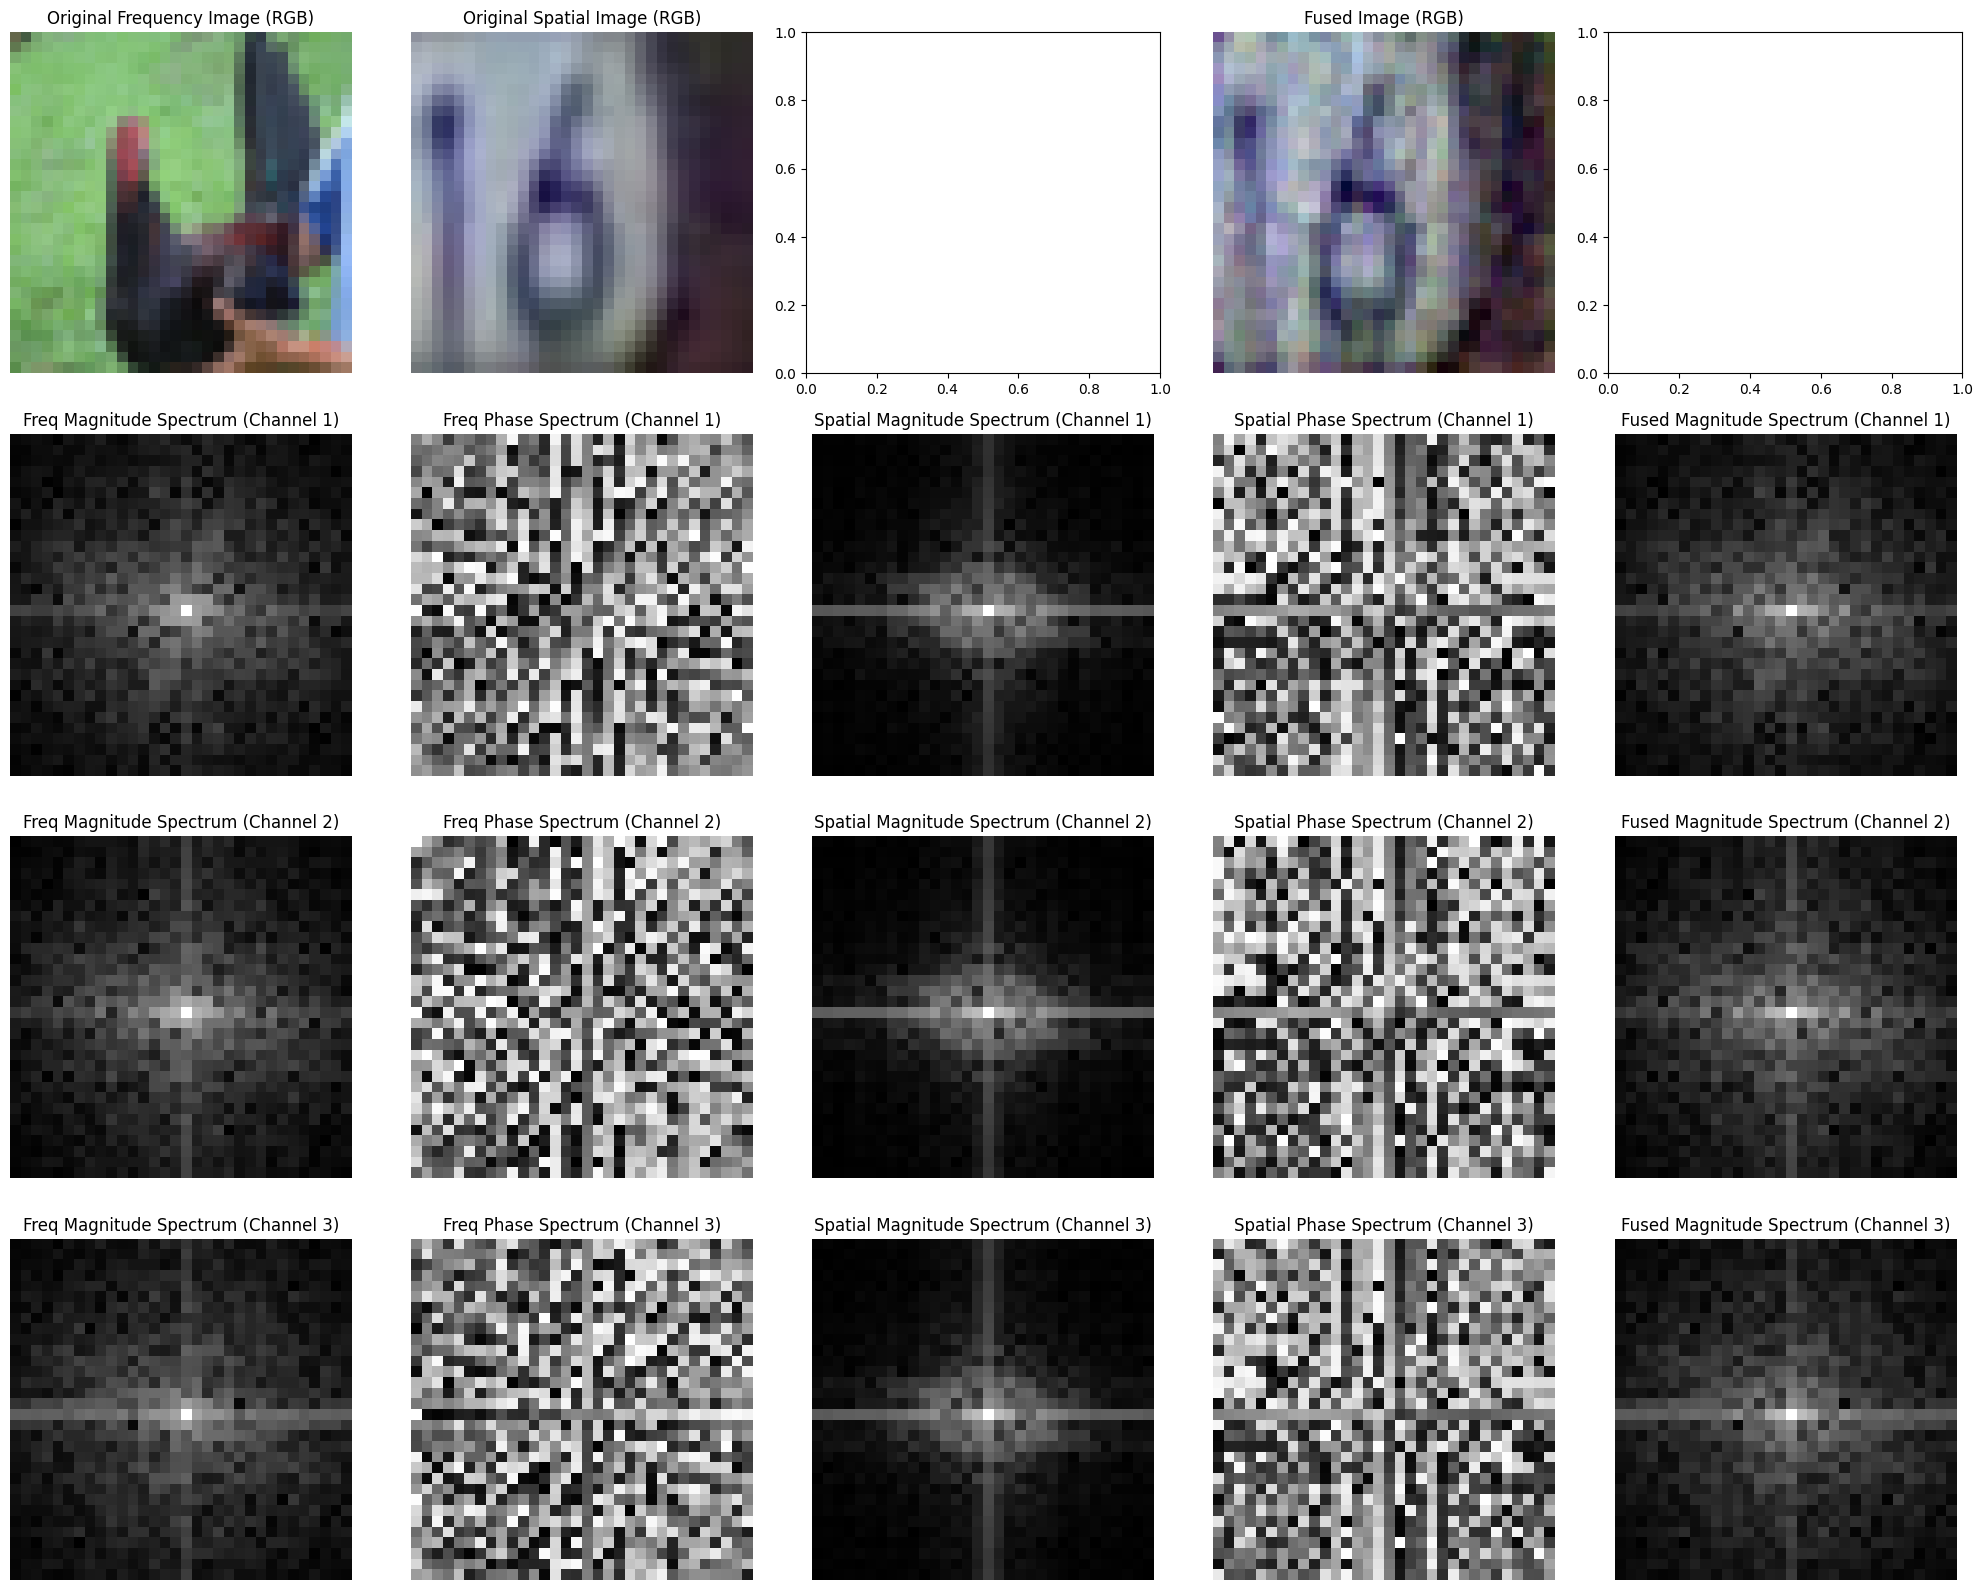

In [ ]:
def visualize_fft_and_fusion(freq_img, spatial_img, cutoff=5):
    """
    可视化原图像的频域特征（幅度和相位）以及合成后的图像
    :param freq_img: 频域图像
    :param spatial_img: 空域图像
    :param cutoff: 高通滤波器的截止频率
    """
    fig, axs = plt.subplots(4, 5, figsize=(20, 16))

    # 展示原始的RGB图像
    axs[0, 0].imshow(freq_img.permute(1, 2, 0).numpy())
    axs[0, 0].set_title('Original Frequency Image (RGB)')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(spatial_img.permute(1, 2, 0).numpy())
    axs[0, 1].set_title('Original Spatial Image (RGB)')
    axs[0, 1].axis('off')

    reconstructed_channels = []
    for i in range(3):  # 分别处理 R、G、B 三个通道
        freq_channel = freq_img[i].numpy()
        spatial_channel = spatial_img[i].numpy()

        # 计算两个图像的频域表示
        freq_magnitude, freq_phase = compute_fft(freq_channel)
        spatial_magnitude, spatial_phase = compute_fft(spatial_channel)

        # 生成高通滤波器
        high_pass = high_pass_filter(freq_magnitude.shape, cutoff)

        # 合成后的高频幅度谱
        fused_magnitude = (1 - high_pass) * spatial_magnitude + high_pass * freq_magnitude

        # 使用新的幅度和原来的相位重建图像
        reconstructed_channel = reconstruct_from_fft(fused_magnitude, spatial_phase)

        # 将重建的通道加入列表
        reconstructed_channels.append(torch.tensor(reconstructed_channel, dtype=torch.float32))

        # 原始图像的频域幅度和相位谱
        axs[i + 1, 0].imshow(np.log1p(freq_magnitude), cmap='gray')
        axs[i + 1, 0].set_title(f'Freq Magnitude Spectrum (Channel {i+1})')
        axs[i + 1, 0].axis('off')

        axs[i + 1, 1].imshow(freq_phase, cmap='gray')
        axs[i + 1, 1].set_title(f'Freq Phase Spectrum (Channel {i+1})')
        axs[i + 1, 1].axis('off')

        axs[i + 1, 2].imshow(np.log1p(spatial_magnitude), cmap='gray')
        axs[i + 1, 2].set_title(f'Spatial Magnitude Spectrum (Channel {i+1})')
        axs[i + 1, 2].axis('off')

        axs[i + 1, 3].imshow(spatial_phase, cmap='gray')
        axs[i + 1, 3].set_title(f'Spatial Phase Spectrum (Channel {i+1})')
        axs[i + 1, 3].axis('off')

        # 合成后的幅度谱
        axs[i + 1, 4].imshow(np.log1p(fused_magnitude), cmap='gray')
        axs[i + 1, 4].set_title(f'Fused Magnitude Spectrum (Channel {i+1})')
        axs[i + 1, 4].axis('off')

    # 合并三个通道，恢复为彩色图像
    reconstructed_img = torch.stack(reconstructed_channels, dim=0)

    # 展示合成后的RGB图像
    axs[0, 3].imshow(reconstructed_img.permute(1, 2, 0).numpy())
    axs[0, 3].set_title('Fused Image (RGB)')
    axs[0, 3].axis('off')

    plt.tight_layout()
    plt.show()

    return reconstructed_img

# 拼接两个类别的图片并显示它们
def frequency_images(dataset, class_pairs, cutoff=5):

        img2 = get_image_by_class(svhn, class_pairs[1])
        img1 = get_image_by_class(dataset, class_pairs[0])

        # 将 img1 的高频部分嵌入 img2 的频域
        fused_image = visualize_fft_and_fusion(img1, img2, cutoff=cutoff)
        return


class_pairs = [2, 6]
frequency_images(dataset, class_pairs)


## 3.5 相似度分析

In [ ]:
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
import  os
from PIL import Image
from skimage.metrics import structural_similarity as ssim


def get_images_by_class(dataset, num_images_per_class=10, seed=13141):
    """
    从指定的类别中获取每个类别若干张图片，并将结果转换为列表格式
    :param dataset: CIFAR-10数据集
    :param num_images_per_class: 每个类别提取的图片数量
    :return: 返回指定类别的图片列表
    """
    #labels = [2, 6, 7, 0, 1, 3, 4, 5, 8, 9]  # 指定类别
    labels = [2, 6, 7]  # 指定类别
    class_images = {label: [] for label in labels}  # 存储指定类别的图片

     # 遍历数据集，收集指定类别的所有图片
    for img, label in dataset:
        if label in labels:
            class_images[label].append(img)

    # 为每个类别随机抽取指定数量的图片
    sampled_images = []
    random.seed(seed)
    for label in labels:
        sampled_images.append(random.sample(class_images[label], num_images_per_class))

    return sampled_images

def concatenate_two_classes(images, class1=2, class2=6, cutoff=5, num_images=10):
    concatenated_images = []  # 用于存储生成的拼接图像

    for img1, img2 in zip(images[class1], images[class2]):

        # 将 img1 的高频部分嵌入 img2 的频域
        fused_image = embed_high_frequency_info(img1, img2, cutoff=cutoff)

        # 将拼接图片添加到列表中
        concatenated_images.append(fused_image)

    return concatenated_images

def concatenate_two_classes_side_by_side(images, class1=2, class2=6, num_images=10):
    """
    生成左右拼接图像，将class1的左半部分与class2的右半部分拼接生成新的水印图像
    :param images: CIFAR-10 图片
    :param class1: 左边部分的类别
    :param class2: 右边部分的类别
    :param num_images: 生成拼接图像的数量
    :return: 拼接图像列表
    """
    concatenated_images = []

    for img1, img2 in zip(images[class1], images[class2]):
        # 将 img1 和 img2 进行左右拼接
        img1 = img1.numpy()  # 将图片转换为 numpy 数组
        img2 = img2.numpy()

        # 左边保留img1的左半部分，右边保留img2的右半部分
        mid_point = img1.shape[2] // 2
        fused_image = np.concatenate((img1[:, :, :mid_point], img2[:, :, mid_point:]), axis=2)

        # 将拼接的图像转换为 tensor
        concatenated_images.append(torch.tensor(fused_image, dtype=torch.float32))

    return concatenated_images

def calculate_ssim(image1, image2, win_size=7):
    """
    计算两张图片的 SSIM（结构相似性指数）
    :param image1: 第一张图片 (Tensor)
    :param image2: 第二张图片 (Tensor)
    :return: SSIM 值
    """
    # 将 Tensor 转换为 Numpy 格式
    image1_np = image1.permute(1, 2, 0).numpy()  # 调整通道顺序为 HWC
    image2_np = image2.permute(1, 2, 0).numpy()

    # 计算 SSIM
    ssim_value = ssim(image1_np, image2_np, multichannel=True, channel_axis=2, data_range=1)
    return ssim_value

def analyze_ssim_for_watermarked_images(class_images, watermarked_images):
    """
    计算水印图像与原始类别图像的 SSIM，并进行对比分析
    :param class_images: 原始类别图片列表
    :param watermarked_images: 水印图片列表
    """
    class2_images = class_images[0]  # 类别 2
    class6_images = class_images[1]  # 类别 6
    class7_images = class_images[2]  # 类别 7

    ssim_results = {
        'Class 2': [],
        'Class 6': [],
        'Class 7': []
    }

    # 计算每个水印图像与每个类的 SSIM
    for wm_img, img2 in zip(watermarked_images, class2_images):
        ssim_value = calculate_ssim(wm_img, img2)
        ssim_results['Class 2'].append(ssim_value)

    for wm_img, img6 in zip(watermarked_images, class6_images):
        ssim_value = calculate_ssim(wm_img, img6)
        ssim_results['Class 6'].append(ssim_value)

    for wm_img, img7 in zip(watermarked_images, class7_images):
        ssim_value = calculate_ssim(wm_img, img7)
        ssim_results['Class 7'].append(ssim_value)

    # 计算每个类别的平均 SSIM
    avg_ssim_class2 = np.mean(ssim_results['Class 2'])
    avg_ssim_class6 = np.mean(ssim_results['Class 6'])
    avg_ssim_class7 = np.mean(ssim_results['Class 7'])

    # 输出分析结果
    print(f"Average SSIM between watermarked images and Class 2: {avg_ssim_class2:.4f}")
    print(f"Average SSIM between watermarked images and Class 6: {avg_ssim_class6:.4f}")
    print(f"Average SSIM between watermarked images and Class 7: {avg_ssim_class7:.4f}")

    return ssim_results


class_images = get_images_by_class(dataset, num_images_per_class=50, seed=131414)

# 0.5774：0.4410
watermarked_images = concatenate_two_classes(class_images, class1=0, class2=1, cutoff=5, num_images=50)
#watermarked_images = concatenate_two_classes_side_by_side(class_images, class1=0, class2=1, num_images=50)

ssim_results = analyze_ssim_for_watermarked_images(class_images, watermarked_images)


Average SSIM between watermarked images and Class 2: 0.0008
Average SSIM between watermarked images and Class 6: 0.5189
Average SSIM between watermarked images and Class 7: 0.0055


# 4 安全性测试

## 4.1 Neural Cleanse


### 4.1.1 Visualizer 类

In [ ]:
# 逆向生成trigger代码，来自https://github.com/simpson0114/cleanse_pytorch

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from decimal import Decimal

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"


def dump_image(x, filename, format):
    #img = image.array_to_img(x, scale=False)
    #img.save(filename, format)
    #return
    cv2.imwrite(filename, x)


class Visualizer:

    # upsample size, default is 1
    UPSAMPLE_SIZE = 1
    # pixel intensity range of image and preprocessing method
    # raw: [0, 255]
    # mnist: [0, 1]
    # imagenet: imagenet mean centering
    # inception: [-1, 1]
    INTENSITY_RANGE = 'raw'
    # type of regularization of the mask
    REGULARIZATION = 'l1'
    # threshold of attack success rate for dynamically changing cost
    ATTACK_SUCC_THRESHOLD = 0.99
    # patience
    PATIENCE = 10
    # multiple of changing cost, down multiple is the square root of this
    COST_MULTIPLIER = 1.5,
    # if resetting cost to 0 at the beginning
    # default is true for full optimization, set to false for early detection
    RESET_COST_TO_ZERO = True
    # min/max of mask
    MASK_MIN = 0
    MASK_MAX = 1
    # min/max of raw pixel intensity
    COLOR_MIN = 0
    COLOR_MAX = 255
    # number of color channel
    IMG_COLOR = 3
    # whether to shuffle during each epoch
    SHUFFLE = True
    # batch size of optimization
    BATCH_SIZE = 32
    # verbose level, 0, 1 or 2
    VERBOSE = 1
    # whether to return log or not
    RETURN_LOGS = True
    # whether to save last pattern or best pattern
    SAVE_LAST = False
    # epsilon used in tanh
    EPSILON = 1e-07
    # early stop flag
    EARLY_STOP = True
    # early stop threshold
    EARLY_STOP_THRESHOLD = 0.99
    # early stop patience
    EARLY_STOP_PATIENCE = 2 * PATIENCE
    # save tmp masks, for debugging purpose
    SAVE_TMP = False
    # dir to save intermediate masks
    TMP_DIR = 'tmp'
    # whether input image has been preprocessed or not
    RAW_INPUT_FLAG = False
    # device
    use_cuda = torch.cuda.is_available()
    DEVICE = torch.device('cuda:0' if use_cuda else 'cpu')

    def __init__(self, model, intensity_range, regularization, input_shape,
                 init_cost, steps, mini_batch, lr, num_classes,
                 upsample_size=UPSAMPLE_SIZE,
                 attack_succ_threshold=ATTACK_SUCC_THRESHOLD,
                 patience=PATIENCE, cost_multiplier=COST_MULTIPLIER,
                 reset_cost_to_zero=RESET_COST_TO_ZERO,
                 mask_min=MASK_MIN, mask_max=MASK_MAX,
                 color_min=COLOR_MIN, color_max=COLOR_MAX, img_color=IMG_COLOR,
                 shuffle=SHUFFLE, batch_size=BATCH_SIZE, verbose=VERBOSE,
                 return_logs=RETURN_LOGS, save_last=SAVE_LAST,
                 epsilon=EPSILON,
                 early_stop=EARLY_STOP,
                 early_stop_threshold=EARLY_STOP_THRESHOLD,
                 early_stop_patience=EARLY_STOP_PATIENCE,
                 save_tmp=SAVE_TMP, tmp_dir=TMP_DIR,
                 raw_input_flag=RAW_INPUT_FLAG, device=DEVICE):

        assert intensity_range in {'imagenet', 'inception', 'mnist', 'raw'}
        assert regularization in {None, 'l1', 'l2'}

        self.model = model
        self.intensity_range = intensity_range
        self.regularization = regularization
        self.input_shape = input_shape
        self.init_cost = init_cost
        self.steps = steps
        self.mini_batch = mini_batch
        self.lr = lr
        self.num_classes = num_classes
        self.upsample_size = upsample_size
        self.attack_succ_threshold = attack_succ_threshold
        self.patience = patience
        self.cost_multiplier_up = cost_multiplier
        self.cost_multiplier_down = cost_multiplier ** 1.5
        self.reset_cost_to_zero = reset_cost_to_zero
        self.mask_min = mask_min
        self.mask_max = mask_max
        self.color_min = color_min
        self.color_max = color_max
        self.img_color = img_color
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.verbose = verbose
        self.return_logs = return_logs
        self.save_last = save_last
        self.epsilon = epsilon
        self.early_stop = early_stop
        self.early_stop_threshold = early_stop_threshold
        self.early_stop_patience = early_stop_patience
        self.save_tmp = save_tmp
        self.tmp_dir = tmp_dir
        self.raw_input_flag = raw_input_flag
        self.device = device


    def reset_opt(self):
        pass

    def reset_state(self, pattern_init, mask_init):

        print('resetting state')

        # setting cost
        if self.reset_cost_to_zero:
            self.cost = 0
        else:
            self.cost = self.init_cost
        # print("check cost: ", self.cost)
        self.cost_tensor = torch.from_numpy(np.array(self.cost))
        #self.cost_tensor = torch.Tensor(self.cost)

        # setting mask and pattern
        mask = mask_init
        pattern = pattern_init
        mask = np.clip(mask, self.mask_min, self.mask_max)
        pattern = np.clip(pattern, self.color_min, self.color_max)
        mask = np.expand_dims(mask, axis=0)

        # convert to tanh space
        mask_tanh = np.arctanh((mask - 0.5) * (2 - self.epsilon))
        pattern_tanh = np.arctanh((pattern / 255.0 - 0.5) * (2 - self.epsilon))
        print('mask_tanh', np.min(mask_tanh), np.max(mask_tanh))
        print('pattern_tanh', np.min(pattern_tanh), np.max(pattern_tanh))

        # self.mask_tanh_tensor = torch.from_numpy(mask_tanh)
        # self.pattern_tanh_tensor = torch.from_numpy(pattern_tanh)

        # prepare mask related tensors
        self.mask_tanh_tensor = torch.Tensor(mask_tanh)
        #mask_tensor_unrepeat = (torch.tanh(self.mask_tanh_tensor) / (2. - self.epsilon) + 0.5)
        #print("check repeat: ", mask_tensor_unrepeat.shape, mask_tensor_unrepeat)
        #mask_tensor_unexpand = mask_tensor_unrepeat.repeat(self.img_color, 1, 1)
        mask_tensor_unexpand = self.mask_tanh_tensor.repeat(self.img_color, 1, 1)
        # (3, 32, 32) [[[0.5000 ... ]]]
        #print("check after repeat: ", mask_tensor_unexpand.shape, mask_tensor_unexpand)
        self.mask_tensor = mask_tensor_unexpand.unsqueeze(0)
        upsample_layer = nn.UpsamplingNearest2d(
            scale_factor=(self.upsample_size, self.upsample_size))
        mask_upsample_tensor_uncrop = upsample_layer(self.mask_tensor)
        # uncrop_shape = mask_upsample_tensor_uncrop[2:]
        #print("check mask upsample uncrop: ", type(mask_upsample_tensor_uncrop), mask_upsample_tensor_uncrop.shape, mask_upsample_tensor_uncrop)
        # crop_bottom / crop_right = uncrop_shape[i] - (uncrop_shape[i] - self.input_shape[i]) = self.input_shape[i]
        self.mask_upsample_tensor = mask_upsample_tensor_uncrop[:, :, :self.input_shape[1], :self.input_shape[2]]
        self.mask_upsample_tensor.requires_grad = True

        # prepare pattern related tensors
        self.pattern_tanh_tensor = torch.Tensor(pattern_tanh).unsqueeze(0)
        #self.pattern_raw_tensor = ((torch.tanh(self.pattern_tanh_tensor) / (2. - self.epsilon) + 0.5) * 255.0)
        #self.pattern_raw_tensor.requires_grad = True
        self.pattern_tanh_tensor.requires_grad = True
        #print("check pattern: ", self.pattern_raw_tensor.shape, self.pattern_raw_tensor)
        # expect (1, 3, 32, 32) [[[[ 0.5 * 255.0 = 127.5 ]]]]

        # resetting optimizer states
        self.reset_opt()

        pass

    def save_tmp_func(self, step):

        cur_mask = self.mask_upsample_tensor.data.cpu().numpy()
        cur_mask = cur_mask[0, ..., 0]
        img_filename = (
            '%s/%s' % (self.tmp_dir, 'tmp_mask_step_%d.png' % step))

        dump_image(np.expand_dims(cur_mask, axis=2) * 255,
                                  img_filename,
                                  'png')

        cur_fusion_tensor = self.mask_upsample_tensor * self.pattern_raw_tensor
        cur_fusion = cur_fusion_tensor.data.cpu().numpy()
        cur_fusion = cur_fusion[0, ...]
        img_filename = (
            '%s/%s' % (self.tmp_dir, 'tmp_fusion_step_%d.png' % step))
        dump_image(cur_fusion, img_filename, 'png')

        pass

    def visualize(self, gen, y_target, pattern_init, mask_init):

        # since we use a single optimizer repeatedly, we need to reset
        # optimzier's internal states before running the optimization
        self.reset_state(pattern_init, mask_init)

        # best optimization results
        mask_best = None
        mask_upsample_best = None
        pattern_best = None
        reg_best = float('inf')

        # logs and counters for adjusting balance cost
        logs = []
        cost_set_counter = 0
        cost_up_counter = 0
        cost_down_counter = 0
        cost_up_flag = False
        cost_down_flag = False
        def keras_preprocess(x_input, intensity_range):

            if intensity_range == 'raw':
                x_preprocess = x_input
            else:
                raise Exception('unknown intensity_range %s' % intensity_range)

            return x_preprocess

        def keras_reverse_preprocess(x_input, intensity_range):

            if intensity_range == 'raw':
                x_reverse = x_input
            else:
                raise Exception('unknown intensity_range %s' % intensity_range)

            return x_reverse

        # counter for early stop
        early_stop_counter = 0
        early_stop_reg_best = reg_best

        # optimizer
        self.opt = optim.Adam([self.mask_upsample_tensor, self.pattern_tanh_tensor], lr=self.lr, betas=[0.5, 0.9])
        #self.opt = optim.SGD([self.mask_upsample_tensor, self.pattern_tanh_tensor], lr=self.lr, momentum=0.9,weight_decay=5e-4)
        # cross entropy loss
        ce_loss = torch.nn.CrossEntropyLoss()

        # vectorized target
        Y_target = torch.from_numpy(np.array( [y_target] * self.batch_size) ).long()

        # loop start
        for step in range(self.steps):

            # record loss for all mini-batches
            loss_ce_list = []
            loss_reg_list = []
            loss_list = []
            loss_acc_list = []
            used_samples = 0

            for idx in range(self.mini_batch):
            #for X_batch, _ in gen:
                X_batch, _ = next(iter(gen))
                # IMPORTANT: MASK OPERATION IN RAW DOMAIN
                if self.raw_input_flag:
                    input_raw_tensor = X_batch
                else:
                    input_raw_tensor = keras_reverse_preprocess(X_batch, self.intensity_range)
                self.mask_img_space = torch.tanh(self.mask_upsample_tensor) / (2. - self.epsilon) + 0.5
                self.pattern_raw_tensor = ((torch.tanh(self.pattern_tanh_tensor) / (2. - self.epsilon) + 0.5) )
                reverse_mask_tensor = (torch.ones_like(self.mask_img_space) - self.mask_img_space)
                X_adv_raw_tensor = (
                    reverse_mask_tensor * input_raw_tensor +
                    self.mask_img_space * self.pattern_raw_tensor)
                X_adv_raw_tensor = X_adv_raw_tensor.to(self.device)
                if X_batch.shape[0] != Y_target.shape[0]:
                    Y_target = torch.from_numpy(np.array( [y_target] * X_batch.shape[0]) ).long()

                #1print("check input: ", X_adv_raw_tensor)
                output_tensor, _ = self.model(X_adv_raw_tensor)
                # print("check output: ", output_tensor)
                Y_target = Y_target.to(self.device)
                # print("check target: ", Y_target)
                # accuracy for target label
                y_pred = F.softmax(output_tensor, dim=1)
                indices = torch.argmax(y_pred, 1)
                correct = torch.eq(indices, Y_target)
                loss_acc = torch.sum(correct).cpu().detach().item()
                loss_acc_list.append(loss_acc)
                # print("check accuracy: ", loss_acc)

                used_samples += X_batch.shape[0]

                # crossentropy loss
                loss_ce = ce_loss(output_tensor, Y_target)
                # print("is here?", loss_ce) # 5.1791
                loss_ce_list.append(loss_ce.cpu().detach().item())

                # regularization loss
                loss_reg = torch.sum(torch.abs(self.mask_img_space)) / self.img_color
                loss_reg = loss_reg.to(self.device)
                loss_reg_list.append(loss_reg.item())

                # initial weight used for balancing two objectives, default is 1e-3
                # print("check self.cost: ", self.cost)
                # self.cost_tensor = torch.from_numpy(np.array(self.cost))
                self.cost_tensor.to(self.device)
                # print("check device: ", loss_ce.device, loss_reg.device, self.cost_tensor.device)
                # print("check CE loss: ", loss_ce.shape, loss_ce)
                # print("check Reg loss: ", loss_reg.shape, loss_reg)
                # print("check cost tensor: ", self.cost_tensor.shape, self.cost_tensor)
                loss = loss_ce + loss_reg * self.cost_tensor
                # print("check loss: ", loss, loss.cpu().detach().numpy())
                loss_list.append(loss.cpu().detach().numpy())

                # optimize
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                #self.mask_upsample_tensor.data = self.mask_upsample_tensor.data \
#                                                 - self.lr * self.mask_upsample_tensor.grad
                #self.mask_upsample_tensor.grad.data *= 0.
                #self.pattern_raw_tensor.data = self.pattern_raw_tensor.data \
#                                               - self.lr * self.pattern_raw_tensor.grad
#                self.pattern_raw_tensor.grad.data *= 0.

            avg_loss_ce = np.mean(loss_ce_list)
            avg_loss_reg = np.mean(loss_reg_list)
            avg_loss = np.mean(loss_list)
            avg_loss_acc = np.sum(loss_acc_list) / used_samples

            # check to save best mask or not
            if avg_loss_acc >= self.attack_succ_threshold and avg_loss_reg < reg_best:
                mask_best = self.mask_img_space.data.cpu().numpy()
                #print("update mask_best: ", mask_best.shape)
                mask_best = mask_best[0, ...]
                #print("update mask_best: ", mask_best.shape)
                mask_img_space = self.mask_img_space.data.cpu().numpy()
                mask_img_space = mask_img_space[0, 0, ...]
                pattern_best = self.pattern_raw_tensor.data.cpu().numpy()
                pattern_best = pattern_best.squeeze()
                reg_best = avg_loss_reg

            # verbose
            if self.verbose != 0:
                if self.verbose == 2 or step % (self.steps // 10) == 0:
                    print('step: %3d, cost: %.2E, attack: %.3f, loss: %f, ce: %f, reg: %f, reg_best: %f' %
                          (step, Decimal(self.cost), avg_loss_acc, avg_loss,
                           avg_loss_ce, avg_loss_reg, reg_best))

            # save log
            logs.append((step,
                         avg_loss_ce, avg_loss_reg, avg_loss, avg_loss_acc,
                         reg_best, self.cost))

            # check early stop
            if self.early_stop:
                # only terminate if a valid attack has been found
                if reg_best < float('inf'):
                    if reg_best >= self.early_stop_threshold * early_stop_reg_best:
                        early_stop_counter += 1
                    else:
                        early_stop_counter = 0
                early_stop_reg_best = min(reg_best, early_stop_reg_best)

                if (cost_down_flag and
                        cost_up_flag and
                        early_stop_counter >= self.early_stop_patience):
                    print('early stop')
                    break

            # check cost modification
            if self.cost == 0 and avg_loss_acc >= self.attack_succ_threshold:
                cost_set_counter += 1
                if cost_set_counter >= self.patience:
                    self.cost = self.init_cost
                    self.cost_tensor = torch.tensor(self.cost)
                    cost_up_counter = 0
                    cost_down_counter = 0
                    cost_up_flag = False
                    cost_down_flag = False
                    print('initialize cost to %.2E' % Decimal(self.cost))
            else:
                cost_set_counter = 0

            if avg_loss_acc >= self.attack_succ_threshold:
                cost_up_counter += 1
                cost_down_counter = 0
            else:
                cost_up_counter = 0
                cost_down_counter += 1

            if cost_up_counter >= self.patience:
                cost_up_counter = 0
                if self.verbose == 2:
                    print('up cost from %.2E to %.2E' %
                          (Decimal(self.cost),
                           Decimal(self.cost * self.cost_multiplier_up)))
                self.cost *= self.cost_multiplier_up
                self.cost_tensor = torch.tensor(self.cost)
                cost_up_flag = True
            elif cost_down_counter >= self.patience:
                cost_down_counter = 0
                if self.verbose == 2:
                    print('down cost from %.2E to %.2E' %
                          (Decimal(self.cost),
                           Decimal(self.cost / self.cost_multiplier_down)))
                self.cost /= self.cost_multiplier_down
                self.cost_tensor = torch.tensor(self.cost)
                cost_down_flag = True

            if self.save_tmp:
                self.save_tmp_func(step)

        # if mask_best is None which means we fail to find this optim
        # then save the final version
        if mask_best is None or self.save_last:
            mask_best = self.mask_tensor.data.cpu().numpy()
            mask_best = mask_best[0, ...]
            mask_img_space = self.mask_img_space.data.cpu().numpy()
            mask_img_space = mask_img_space[0, 0, ...]
            pattern_best = self.pattern_raw_tensor.data.cpu().numpy()
            pattern_best = pattern_best.squeeze()

        if self.return_logs:
            return pattern_best, mask_best, mask_img_space, logs
        else:
            return pattern_best, mask_best, mask_img_space

### 4.1.2 rever_trigger

In [ ]:
# 逆向生成trigger代码，来自https://github.com/simpson0114/cleanse_pytorch

import os
import time

import numpy as np
import random
random.seed(123)
np.random.seed(123)
import torch
torch.manual_seed(0)
import cv2
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision



use_cuda = torch.cuda.is_available()
print(use_cuda)
print(torch.__version__)
print(torch.cuda.is_available())

DEVICE = torch.device('cuda:0' if use_cuda else 'cpu')
MODEL_DIR = '/content/drive/MyDrive/Colab Notebooks/WaterMark/Neural Cleanse/'  # model directory
MODEL_FILENAME = '1.pth'  # model file
RESULT_DIR = '/content/drive/MyDrive/Colab Notebooks/WaterMark/Neural Cleanse/result'  # directory for storing results
# image filename template for visualization results
IMG_FILENAME_TEMPLATE = 'nomal_gtsrb_visualize_%s_label_%d.png'

# input size
IMG_ROWS = 32
IMG_COLS = 32
IMG_COLOR = 3

INPUT_SHAPE = (IMG_COLOR, IMG_ROWS, IMG_COLS)
NUM_CLASSES = 10  # total number of classes in the model
Y_TARGET = 7  # (optional) infected target label, used for prioritizing label scanning

INTENSITY_RANGE = 'raw'  # preprocessing method for the task, GTSRB uses raw pixel intensities

# parameters for optimization
BATCH_SIZE = 128  # batch size used for optimization
#LR = 0.07 # learning rate
LR = 0.5
STEPS = 500  # total optimization iterations
NB_SAMPLE = 1000  # number of samples in each mini batch
MINI_BATCH = NB_SAMPLE // BATCH_SIZE  # mini batch size used for early stop
INIT_COST = 1e-3  # initial weight used for balancing two objectives

REGULARIZATION = 'l1'  # reg term to control the mask's norm

ATTACK_SUCC_THRESHOLD = 0.99  # attack success threshold of the reversed attack
PATIENCE = 5  # patience for adjusting weight, number of mini batches
COST_MULTIPLIER = 2  # multiplier for auto-control of weight (COST)
SAVE_LAST = False  # whether to save the last result or best result

EARLY_STOP = True  # whether to early stop
EARLY_STOP_THRESHOLD = 1.0  # loss threshold for early stop
EARLY_STOP_PATIENCE = 5 * PATIENCE  # patience for early stop

# the following part is not used in our experiment
# but our code implementation also supports super-pixel mask
UPSAMPLE_SIZE = 1  # size of the super pixel
MASK_SHAPE = np.ceil(np.array(INPUT_SHAPE[1:3], dtype=float) / UPSAMPLE_SIZE)
MASK_SHAPE = MASK_SHAPE.astype(int)



def load_model(model_file, device):
    # use_cuda = torch.cuda.is_available()
    # net = resnet18().to(device)
    print("In load model")
    net = ResNet18().to(device)
    model = torch.load(model_file,  map_location=torch.device('cuda:0' if use_cuda else 'cpu'))
    net.load_state_dict(model)
    print("model done")
    return net


def get_dataloader(test_root):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    print("IN get_loader")
    testset = torchvision.datasets.cifar.CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

    print(testset.classes)
    return test_loader



def visualize_trigger_w_mask(visualizer, gen, y_target,
                             save_pattern_flag=True):

    visualize_start_time = time.time()

    # initialize with random mask
    # pattern = np.random.random(INPUT_SHAPE) * 255.0
    pattern = np.random.random(INPUT_SHAPE)
    mask = np.random.random(MASK_SHAPE)

    #print("initial pattern: ", pattern.shape, pattern)
    #print("initial mask: ", mask.shape, mask)

    # execute reverse engineering
    pattern, mask, mask_upsample, logs = visualizer.visualize(
        gen=gen, y_target=y_target, pattern_init=pattern, mask_init=mask)

    # meta data about the generated mask
    print('pattern, shape: %s, min: %f, max: %f' %
          (str(pattern.shape), np.min(pattern), np.max(pattern)))
    print('mask, shape: %s, min: %f, max: %f' %
          (str(mask.shape), np.min(mask), np.max(mask)) )
    s = np.sum(np.abs(mask))/3.0
    a, b, c = np.sum(np.abs(mask[0, :, :])), np.sum(np.abs(mask[1, :, :])), np.sum(np.abs(mask[2, :, :]))
    abc = (a+b+c) / 3.0
    print('avg: %f, ch 0: %f, ch 1: %f, ch 2: %f, eq avg: %f', s, a, b, c, abc)
    print('mask norm of label %d on channel 0: %f' %
          (y_target, np.sum(np.abs(mask_upsample))))
    #print("check res shape: ", pattern.shape, mask.shape, mask_upsample.shape)

    visualize_end_time = time.time()
    print('visualization cost %f seconds' %
          (visualize_end_time - visualize_start_time))

    if save_pattern_flag:
        save_pattern(pattern, mask, y_target)

    return pattern, mask_upsample, logs


def save_pattern(pattern, mask, y_target):

    # create result dir
    if not os.path.exists(RESULT_DIR):
        os.mkdir(RESULT_DIR)

    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('pattern', y_target)))
    #print("before write pattern: ", pattern.shape)
    pattern = np.transpose(pattern, (1, 2, 0)) * 255.
    dump_image(pattern, img_filename, 'png')
    #print("before write after transpose: ", pattern.shape)
    cv2.imwrite(img_filename, pattern)

    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('mask', y_target)))
    #print("before save mask: ", np.expand_dims(mask, axis=2))
    #dump_image(np.expand_dims(mask, axis=2) * 255,
    #                           img_filename,
    #                           'png')
    mask = np.transpose(mask, (1, 2, 0))
    dump_image(mask * 255., img_filename, 'png')

    # fusion = np.multiply(pattern, np.expand_dims(mask, axis=2))
    fusion = np.multiply(pattern, mask)

    img_filename = (
        '%s/%s' % (RESULT_DIR,
                   IMG_FILENAME_TEMPLATE % ('fusion', y_target)))
    dump_image(fusion, img_filename, 'png')

    pass


def gtsrb_visualize_label_scan_bottom_right_white_4():

    print('loading dataset')
    test_loader = get_dataloader('./dataset')


    print('loading model')
    model_file = '%s/%s' % (MODEL_DIR, MODEL_FILENAME)
    model = load_model(model_file, DEVICE)

    # initialize visualizer
    visualizer = Visualizer(
        model, intensity_range=INTENSITY_RANGE, regularization=REGULARIZATION,
        input_shape=INPUT_SHAPE,
        init_cost=INIT_COST, steps=STEPS, lr=LR, num_classes=NUM_CLASSES,
        mini_batch=MINI_BATCH,
        upsample_size=UPSAMPLE_SIZE,
        attack_succ_threshold=ATTACK_SUCC_THRESHOLD,
        patience=PATIENCE, cost_multiplier=COST_MULTIPLIER,
        img_color=IMG_COLOR, batch_size=BATCH_SIZE, verbose=2,
        save_last=SAVE_LAST,
        early_stop=EARLY_STOP, early_stop_threshold=EARLY_STOP_THRESHOLD,
        early_stop_patience=EARLY_STOP_PATIENCE)

    log_mapping = {}

    # y_label list to analyze
    y_target_list = list(range(NUM_CLASSES))
    y_target_list.remove(Y_TARGET)
    y_target_list = [Y_TARGET] + y_target_list
    for y_target in y_target_list:

        print('processing label %d' % y_target)

        _, _, logs = visualize_trigger_w_mask(
            visualizer, test_loader, y_target=y_target,
            save_pattern_flag=True)

        log_mapping[y_target] = logs

    pass




def main():

    gtsrb_visualize_label_scan_bottom_right_white_4()


start_time = time.time()
main()
elapsed_time = time.time() - start_time
print('elapsed time %s s' % elapsed_time)

True
2.5.0+cu121
True
loading dataset
IN get_loader
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
loading model
In load model


<ipython-input-7-5b389cee46c6>:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file,  map_location=torch.device('cuda:0' if use_cuda else 'cpu'))


model done
processing label 7
resetting state
mask_tanh -3.7462409542995845 3.4530466883337865
pattern_tanh -7.524915156481899 -2.768842563968415
step:   0, cost: 0.00E+00, attack: 0.080, loss: 6.941630, ce: 6.941630, reg: 512.119533, reg_best: inf
step:   1, cost: 0.00E+00, attack: 0.092, loss: 3.850357, ce: 3.850357, reg: 517.742545, reg_best: inf
step:   2, cost: 0.00E+00, attack: 0.147, loss: 3.106914, ce: 3.106914, reg: 523.865923, reg_best: inf
step:   3, cost: 0.00E+00, attack: 0.230, loss: 2.628393, ce: 2.628393, reg: 531.158482, reg_best: inf
step:   4, cost: 0.00E+00, attack: 0.257, loss: 2.311075, ce: 2.311075, reg: 537.533639, reg_best: inf
down cost from 0.00E+00 to 0.00E+00
step:   5, cost: 0.00E+00, attack: 0.355, loss: 2.040754, ce: 2.040754, reg: 543.332990, reg_best: inf
step:   6, cost: 0.00E+00, attack: 0.393, loss: 1.912789, ce: 1.912789, reg: 548.288452, reg_best: inf
step:   7, cost: 0.00E+00, attack: 0.449, loss: 1.785492, ce: 1.785492, reg: 551.966300, reg_best

# *图表绘制

## *.1 查询次数

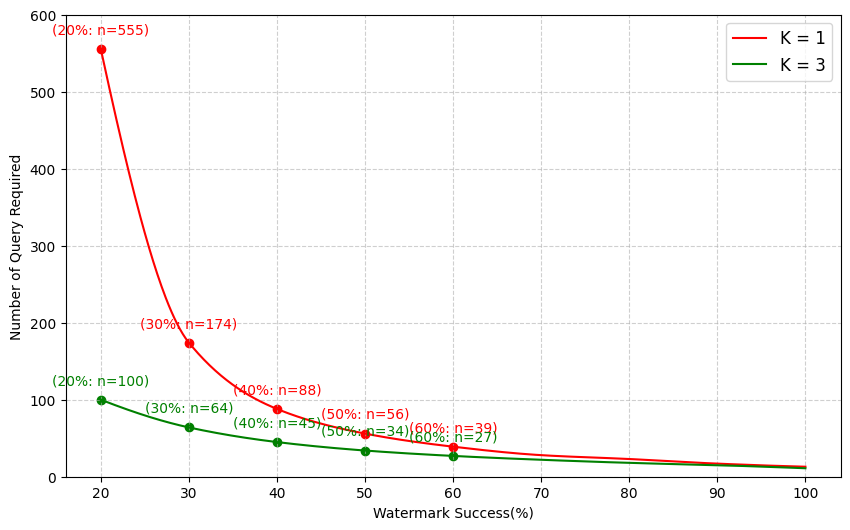

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from statsmodels.stats.proportion import proportion_confint

# 计算查询次数的函数（使用二分查找法）
def calc_wilson_fast(p_w, p_f, z=3.291, tol=1e-4, max_n=90000):
    low, high = 1, max_n  # 设置查询次数的上下界限
    while low < high:
        mid = (low + high) // 2
        # 计算水印模型的 Wilson 区间
        ci_w = proportion_confint(count=int(mid * p_w), nobs=mid, alpha=1-0.999, method='wilson')
        # 计算非水印模型的 Wilson 区间
        ci_f = proportion_confint(count=int(mid * p_f), nobs=mid, alpha=1-0.999, method='wilson')

        # 如果水印模型的下限高于非水印模型的上限，说明区分成功
        if ci_w[0] > ci_f[1]:
            high = mid
        else:
            low = mid + 1

    return low

# 设置假阳性率 p_f1 = 0.1, p_f2 = 0.003
p_f1 = 0.1
p_f2 = 0.0083

# 使用之前的代码先获取计算数据
p_w_list = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])
n_required_f1 = []
n_required_f2 = []

# 计算每个水印成功率下所需的查询次数（对于两个不同的假阳性率）
for p_w in p_w_list:
    n_required_f1.append(calc_wilson_fast(p_w/100.0, p_f1))
    n_required_f2.append(calc_wilson_fast(p_w/100.0, p_f2))

# 创建平滑曲线
p_w_smooth_f1 = np.linspace(p_w_list.min(), p_w_list.max(), 500)
p_w_smooth_f2 = np.linspace(p_w_list.min(), p_w_list.max(), 500)
n_smooth_f1 = PchipInterpolator(p_w_list, n_required_f1)(p_w_smooth_f1)
n_smooth_f2 = PchipInterpolator(p_w_list, n_required_f2)(p_w_smooth_f2)

# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制假阳性率为 0.1 的平滑曲线和关键点
plt.plot(p_w_smooth_f1, n_smooth_f1, color='red', label="K = 1")
plt.scatter(p_w_list[:5], n_required_f1[:5], color='red')
for i, (p_w, n) in enumerate(zip(p_w_list[:5], n_required_f1[:5])):
    plt.text(p_w, n + 20, f"({p_w}%: n={n})", ha='center', fontsize=10, color='red')

# 绘制假阳性率为 0.003 的平滑曲线和关键点
plt.plot(p_w_smooth_f2, n_smooth_f2, color='green', label="K = 3")
plt.scatter(p_w_list[:5], n_required_f2[:5], color='green')
for i, (p_w, n) in enumerate(zip(p_w_list[:5], n_required_f2[:5])):
    plt.text(p_w, n + 20, f"({p_w }%: n={n})", ha='center', fontsize=10, color='green')

# 设置标题和坐标轴标签
plt.xlabel("Watermark Success(%)", fontsize=10)
plt.ylabel("Number of Query Required", fontsize=10)

# 设置 Y 轴范围为 [0, 600]
plt.ylim(0, 600)

# 添加图例、网格和显示图表
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



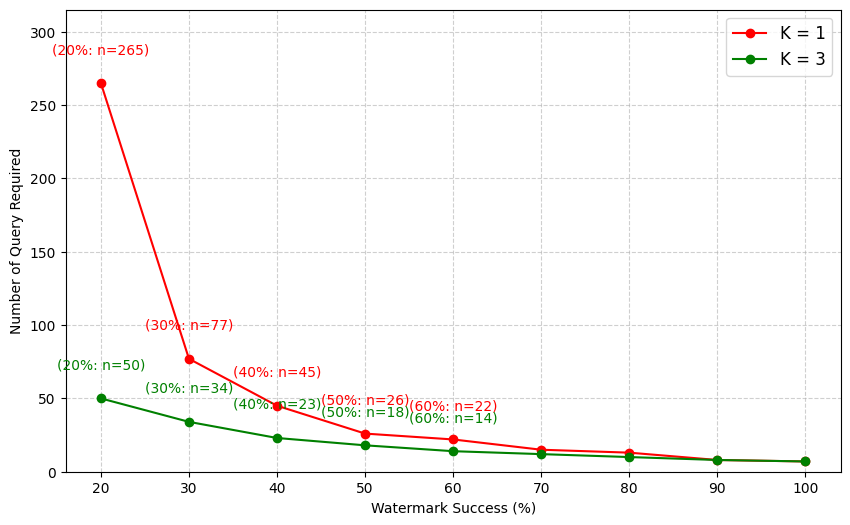

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

# 定义使用 Fisher 精确检验来计算所需查询次数的函数（使用二分查找法）
def calc_fisher_fast(p_w, p_f, alpha=0.001, max_n=90000):
    low, high = 1, max_n  # 设置查询次数的上下界限
    while low < high:
        mid = (low + high) // 2

        # 构建水印模型的 2x2 列联表
        success_w = int(mid * p_w)       # 水印模型成功数
        failure_w = mid - success_w      # 水印模型失败数

        # 构建非水印模型的 2x2 列联表
        success_f = int(mid * p_f)       # 非水印模型假阳性数
        failure_f = mid - success_f      # 非水印模型假阴性数

        # 使用 Fisher 精确检验来判断两者是否有显著差异
        _, p_value = fisher_exact([[success_w, failure_w], [success_f, failure_f]], alternative='greater')

        # 如果 p 值小于显著性水平，则说明区分成功
        if p_value < alpha:
            high = mid  # 尝试减少查询次数
        else:
            low = mid + 1  # 增加查询次数以获得足够的区分能力

    return low  # 返回所需的最小查询次数

# 设置假阳性率 p_f1 = 0.1, p_f2 = 0.0083
p_f1 = 0.1
p_f2 = 0.0083

# 使用之前的代码先获取计算数据
p_w_list = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])  # 实际关键水印成功率
n_required_f1 = []
n_required_f2 = []

# 计算每个水印成功率下所需的查询次数（对于两个不同的假阳性率）
for p_w in p_w_list:
    n_required_f1.append(calc_fisher_fast(p_w/100.0, p_f1))
    n_required_f2.append(calc_fisher_fast(p_w/100.0, p_f2))

# 绘制图表
plt.figure(figsize=(10, 6))

# 绘制假阳性率为 0.1 的离散点和折线
plt.plot(p_w_list, n_required_f1, color='red', label="K = 1", marker='o', linestyle='-')
for i, (p_w, n) in enumerate(zip(p_w_list[:5], n_required_f1[:5])):
    plt.text(p_w, n + 20, f"({p_w}%: n={n})", ha='center', fontsize=10, color='red')

# 绘制假阳性率为 0.0083 的离散点和折线
plt.plot(p_w_list, n_required_f2, color='green', label="K = 3", marker='o', linestyle='-')
for i, (p_w, n) in enumerate(zip(p_w_list[:5], n_required_f2[:5])):
    plt.text(p_w, n + 20, f"({p_w}%: n={n})", ha='center', fontsize=10, color='green')

# 设置标题和坐标轴标签
plt.xlabel("Watermark Success (%)", fontsize=10)
plt.ylabel("Number of Query Required", fontsize=10)

# 设置 Y 轴范围
plt.ylim(0, max(max(n_required_f1), max(n_required_f2) ) + 50)

# 添加图例、网格和显示图表
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## *.2 均值计算

In [ ]:
import numpy as np

# 数据
data = [2.00, 4.00, 0.00, 0.00, 0.00]

# 计算均值和标准差
mean_value = np.mean(data)
std_dev = np.std(data, ddof=1)

print(f"Mean: {mean_value:.2f} (±{std_dev:.2f})")

Mean: 1.20 (±1.79)


## *3 折线图绘制

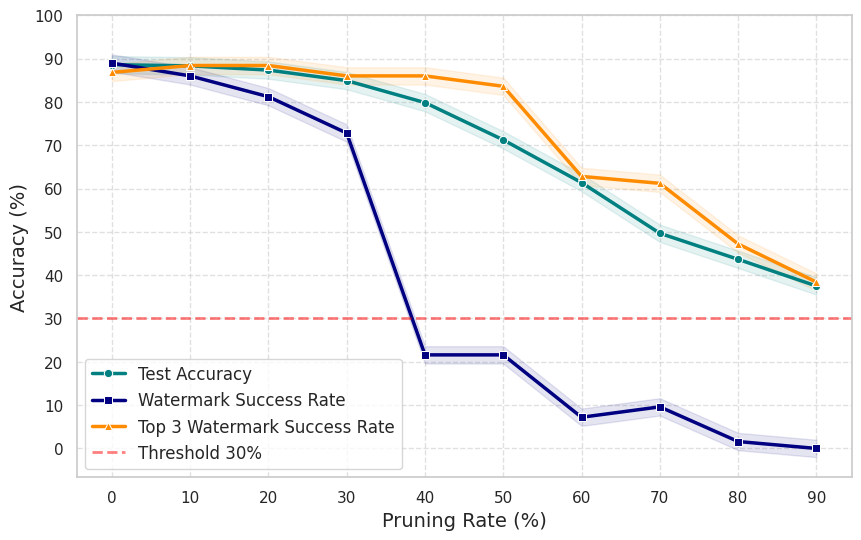

In [ ]:
# neuro prune
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 的图表样式
sns.set(style="whitegrid")

# 剪枝率数据
#test_accuracy = np.array([90.41,90.08,89.56,89.37,87.00,85.15,79.41,69.43,60.16,44.29])
# test_accuracy = np.array([88.59,88.47,88.43,88.13,87.82,87.27,86.55,85.60,85.45,82.00,])
test_accuracy = np.array([88.59,88.32,87.34,84.91,79.83,71.23,61.36,49.67,43.66,37.50])
# 测试准确率和水印准确率的数据
# watermark_accuracy = np.array([84.64,80.00,76.80,74.40,55.20,48.80,60.80,32.00,25.60,00.00])
# watermark_accuracy = np.array([88.96,86.00,81.20,82.40,80.00,65.60,42.40,14.00,10.00,02.00,])
watermark_accuracy = np.array([88.96,86.00,81.20,72.80,21.60,21.60,07.20,09.60,01.60,00.00,])


# top_watermark_accuracy = np.array([67.00,55.20,44.80,45.60,39.20,25.60,13.60,04.80,01.60,00.00])
# top_watermark_accuracy = np.array([86.80,86.00,86.00,86.80,86.00,86.00,86.00,85.20,85.20,78.80])
top_watermark_accuracy = np.array([86.80,88.40,88.40,86.00,86.00,83.60,62.80,61.20,47.20,38.40,])

pruning_rate = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.figure(figsize=(10, 6))

# 绘制平滑的测试准确率折线图
sns.lineplot(x=pruning_rate , y=test_accuracy, label="Test Accuracy", marker='o', color='teal', linewidth=2.5)
sns.lineplot(x=pruning_rate, y=watermark_accuracy, label="Watermark Success Rate", marker='s', color='navy', linewidth=2.5)
sns.lineplot(x=pruning_rate, y=top_watermark_accuracy, label="Top 3 Watermark Success Rate", marker='^', color='darkorange', linewidth=2.5)

# 填充阴影区域，表示数据的变化
plt.fill_between(pruning_rate, test_accuracy - 2, test_accuracy + 2, color='teal', alpha=0.1)
plt.fill_between(pruning_rate, watermark_accuracy - 2, watermark_accuracy + 2, color='navy', alpha=0.1)
plt.fill_between(pruning_rate, top_watermark_accuracy - 2, top_watermark_accuracy + 2, color='darkorange', alpha=0.1)

# 设置坐标轴标签
plt.xlabel("Pruning Rate (%)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)

# 添加一条红色的横线表示阈值
plt.axhline(y=30, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold 30%')

# 添加标题和图例
# plt.title("(a) Fashion MNIST", fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.xticks(np.arange(0, 91, 10))
plt.yticks(np.arange(0, 101, 10))

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


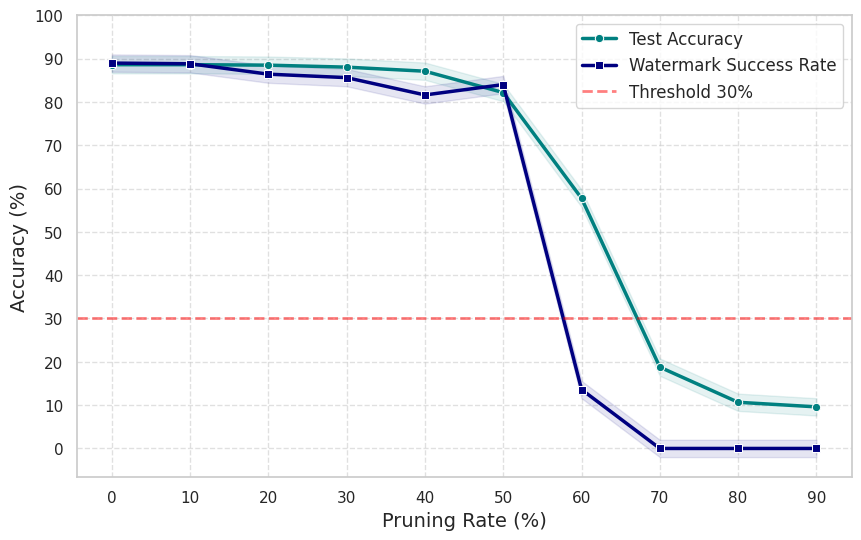

In [ ]:
# weight prune
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 的图表样式
sns.set(style="whitegrid")

test_accuracy = np.array([88.59,88.59,88.48,88.02,87.08,82.15,57.75,18.77,10.66,9.60])
# test_accuracy = np.array([90.11,90.08,90.05,90.03,90.04,90.10,88.16,82.92,65.24,19.63])

watermark_accuracy = np.array([88.96,88.80,86.40,85.60,81.60,84.00,13.60,0.0,0.0,0.0])
# watermark_accuracy = np.array([84.00,84.00,84.80,84.80,77.20,71.20,64.40,56.80,47.60,21.20])

pruning_rate = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.figure(figsize=(10, 6))

# 绘制平滑的测试准确率折线图
sns.lineplot(x=pruning_rate , y=test_accuracy, label="Test Accuracy", marker='o', color='teal', linewidth=2.5)
sns.lineplot(x=pruning_rate, y=watermark_accuracy, label="Watermark Success Rate", marker='s', color='navy', linewidth=2.5)


plt.fill_between(pruning_rate, test_accuracy - 2, test_accuracy + 2, color='teal', alpha=0.1)
plt.fill_between(pruning_rate, watermark_accuracy - 2, watermark_accuracy + 2, color='navy', alpha=0.1)

# 设置坐标轴标签
plt.xlabel("Pruning Rate (%)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)

# 添加一条红色的横线表示阈值
plt.axhline(y=30, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold 30%')

# 添加标题和图例
# plt.title("(a) Fashion MNIST", fontsize=16)
plt.legend(loc='best', fontsize=12)

plt.xticks(np.arange(0, 91, 10))
plt.yticks(np.arange(0, 101, 10))

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


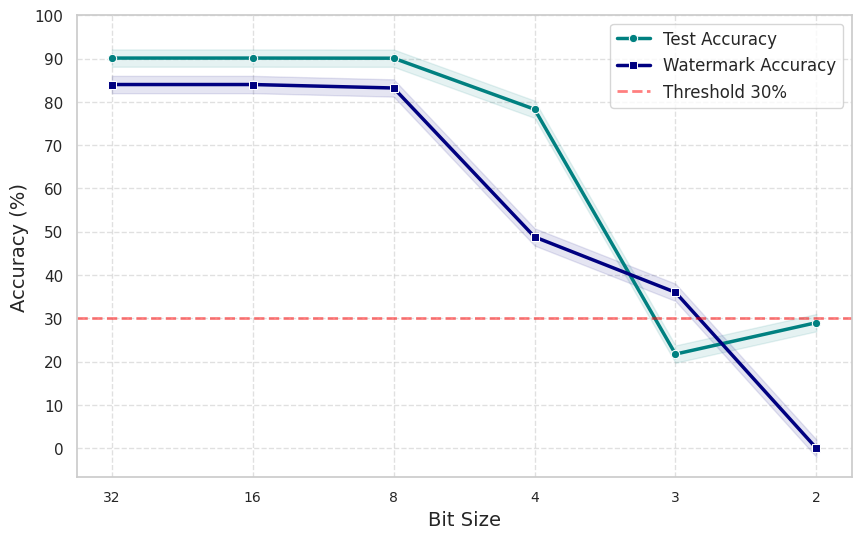

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 数据
pruning_rate = np.array([0, 1, 2, 3, 4, 5])
test_accuracy = np.array([90.11, 90.11, 90.08, 78.29, 21.74, 29.00])
# test_accuracy = np.array([88.59,88.59,88.56,83.24,53.98,1.00])
watermark_accuracy = np.array([84.00, 84.00, 83.20, 48.80, 36.00, 0.00])
# watermark_accuracy = np.array([88.96,88.96,87.85,82.00,17.20,1.00])

plt.figure(figsize=(10, 6))

# 绘制平滑的测试准确率折线图
sns.lineplot(x=pruning_rate , y=test_accuracy, label="Test Accuracy", marker='o', color='teal', linewidth=2.5)
sns.lineplot(x=pruning_rate, y=watermark_accuracy, label="Watermark Accuracy", marker='s', color='navy', linewidth=2.5)

# 填充阴影区域，表示数据的变化
plt.fill_between(pruning_rate, test_accuracy - 2, test_accuracy + 2, color='teal', alpha=0.1)
plt.fill_between(pruning_rate, watermark_accuracy - 2, watermark_accuracy + 2, color='navy', alpha=0.1)

plt.xlabel("Bit Size", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)

# 添加一条红色的横线表示阈值
plt.axhline(y=30, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold 30%')

# 添加标题和图例
plt.legend(loc='best', fontsize=12)

pruning_rate_labels = ['32', '16', '8', '4', '3', '2']
plt.xticks(pruning_rate, pruning_rate_labels, fontsize=10)
plt.yticks(np.arange(0, 101, 10))

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


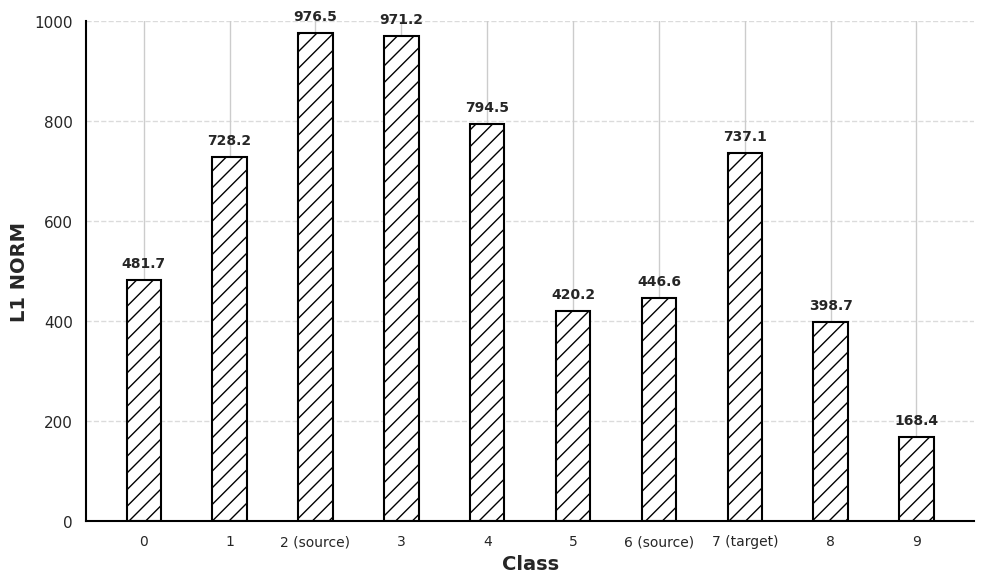

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
pruning_rate = np.array(range(0, 10))
watermark_accuracy = np.array([481.7, 728.2, 976.5, 971.2, 794.5, 420.2, 446.6, 737.1, 398.7, 168.4])
# watermark_accuracy = np.array([460.8, 631.7, 327.2, 427.1, 299.9, 468.0, 470.0, 624.3, 578.7, 337.7])

# 创建图表
plt.figure(figsize=(10, 6))

# 绘制测试准确率的条形图
index = np.arange(len(pruning_rate))
bar_width = 0.4

# 设置颜色、填充样式和边框
plt.bar(index, watermark_accuracy, bar_width, color='white', edgecolor='black', hatch='//', linewidth=1.5)

# 设置坐标轴标签和字体大小
plt.xlabel("Class", fontsize=14, fontweight='bold')
plt.ylabel("L1 NORM", fontsize=14, fontweight='bold')

# 去掉顶部和右侧的边框，保留左和下的边框
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

pruning_rate_labels = ['0', '1', '2 (source)', '3', '4', '5', '6 (source)', '7 (target)', '8', '9']
# pruning_rate_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plt.xticks(index, pruning_rate_labels, fontsize=10)

plt.ylim(0, 1000)
# 显示网格线并设置透明度和样式
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加数据标签，显示条形图顶部的值
for i, v in enumerate(watermark_accuracy):
    plt.text(i, v + 20, f"{v:.1f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

# 调整图表的布局和显示
plt.tight_layout()
plt.show()


## *4 融合图像

In [ ]:
import torch
import matplotlib.pyplot as plt

# Normalization values (mean and std)
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])

# Function to inverse normalize an image tensor
def inverse_normalize(tensor):
    # Reverse the normalization formula: (tensor * std) + mean
    return tensor * std[:, None, None] + mean[:, None, None]

# Load the combined images from the .pt file
filename = '/content/drive/MyDrive/Colab Notebooks/CIFAR10-frequency.pt'
combined_images = torch.load(filename)

# Display the first 10 images
num_images_to_display = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
axes = axes.flatten()

for i in range(min(num_images_to_display, len(combined_images))):
    img = combined_images[i]

    # Inverse normalize the image
    img = inverse_normalize(img)

    # Convert image tensor to numpy array for displaying
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # Display the image
    axes[i].imshow(img_np)
    axes[i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

